In [45]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary
from matplotlib import pyplot as plt

In [2]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [3]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
len(df_train)/len(df), len(df_val)/len(df), len(df), len(df_val)

(0.9642465458145908, 0.035753454185409164, 844338, 30188)

In [4]:
final_train = True

In [5]:
def get_metric(sales, sales_):
    return np.sqrt((((sales - sales_)/sales)**2).sum()/len(sales))


$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}$


In [6]:
df_train.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week',
       'Day', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitatio

In [7]:
set(df_train.columns)-set(df_val.columns)

set()

In [8]:
df_train['Events']

30188     20
30189     20
30190      0
30191     20
30192     20
          ..
844333    10
844334    10
844335    10
844336     1
844337    10
Name: Events, Length: 814150, dtype: int64

In [9]:
df_train['Sales'].max()

41551

In [10]:
max_sales = df_train['Sales'].max()
df.loc[:, 'Sales_norm'] = df['Sales'].values/max_sales

In [11]:
df_train.loc[:, 'Sales_norm'] = df_train['Sales'].values/max_sales
df_val.loc[:, 'Sales_norm'] = df_val['Sales'].values/max_sales

C:\Users\fvillarino\Anaconda3\envs\dip-ml-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\fvillarino\Anaconda3\envs\dip-ml-env\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [12]:
print('Train:')
print(get_metric(df_train['Sales_norm'], 
                 df_train['Sales_norm'].mean()))
print('Val:')
get_metric(df_val['Sales_norm'], 
           df_train['Sales_norm'].mean())

Train:
0.6371089378658743
Val:


0.5496723521813329

In [13]:
def get_mean_by_column(column, sales_str):
    group_means_dict = {}
    group_mean_list = []
    for col_value, group_df in df_train.groupby(column):
        group_mean =  group_df[group_df[sales_str] > 0][sales_str].mean()
        group_means_dict[col_value] = group_mean
        group_mean_list.append(group_mean)
    print('Train:', get_metric(df_train[sales_str], 
                               df_train[column].apply(group_means_dict.get)))
    print('Val:', get_metric(df_val[sales_str], 
                             df_val[column].apply(group_means_dict.get)))
    return group_means_dict, group_mean_list

In [14]:
# Media por store
_ = get_mean_by_column('Store', 'Sales_norm')

Train: 0.3960913521241833
Val: 0.3071746085338872


In [15]:
# Media por dia de la semana
_ = get_mean_by_column('DayOfWeek', 'Sales_norm')

Train: 0.6008874922754364
Val: 0.5061392186635405


In [16]:
# Media por numera de semana (1-52)
_ = get_mean_by_column('Week', 'Sales_norm')

Train: 0.6077405789213655
Val: 0.5171468581189804


In [17]:
_ = get_mean_by_column('Month', 'Sales_norm')

Train: 0.6326710739722268
Val: 0.544465040070309


In [18]:
_ = get_mean_by_column('StateHoliday', 'Sales_norm')

Train: 0.6379671046048598
Val: 0.5494193814701794


In [19]:
_ = get_mean_by_column('SchoolHoliday', 'Sales_norm')

Train: 0.6352131730794401
Val: 0.5522886254888293


In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import matplotlib as plt

In [21]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [22]:
def get_keras_LR(X_columns, hidden_units=1):
    inputs = []
    activation = 'linear'
    if hidden_units>1:
        activation = 'relu'
    for i, col in enumerate(X_columns):
        inp = Input(shape=(X_train[i].shape[1],), name=f"{col}_input")
        inputs.append(inp)
    if len(X_columns)>1:
        concat_out = Concatenate()(inputs)
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(concat_out)
    else:
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(inputs[0])
    if hidden_units>1:
        dense_out = Dense(1, name='Dense_out')(dense_out)
    model = Model(inputs, dense_out)
    model.compile(optimizers.Adam(lr=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model


def get_embedings_NN(X_columns, hidden_units = 20, activation = 'relu'):
    embed_outs = []
    inputs = []
    for i, col in enumerate(X_columns):
        inp = Input(shape=(1,), name=f"{col}_input")
        inputs.append(inp)
        if col in embed_outs_dict:
            embed_out = Embedding(len(np.unique(X_train[i])), embed_outs_dict[col], name=f"{col}_embedding", mask_zero=False)(inp)
            out = Flatten(name=f"{col}_flatten")(embed_out)
            embed_outs.append(out)
        else:
            embed_outs.append(inp)
        
    if len(X_columns)>1:
        concat_out = Concatenate()(embed_outs)
        dense_out = Dense(hidden_units, activation=activation)(concat_out)
    else:
        dense_out = Dense(hidden_units, activation=activation)(out)
    out = Dense(1)(dense_out)
    model = Model(inputs, out)
    model.compile(optimizers.Adam(lr=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model

In [23]:
df_train

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw,Sales_norm
30188,34565,0,1,2015-06-30,5735,568,1,1.273237,0,-0.466372,...,1.072424,0,0,0,0,2,0,0,4,0.138023
30189,34566,1,1,2015-06-30,9863,877,1,1.273237,0,-0.466372,...,1.072424,0,0,0,0,2,0,0,4,0.237371
30190,34567,2,1,2015-06-30,13261,1072,1,1.273237,0,2.144211,...,1.072424,0,0,2,0,2,5,0,4,0.319150
30191,34568,3,1,2015-06-30,13106,1488,1,1.273237,0,-0.466372,...,1.072424,0,0,0,0,2,0,0,4,0.315420
30192,34569,4,1,2015-06-30,6635,645,1,1.273237,0,-0.466372,...,1.072424,0,0,0,0,2,0,0,4,0.159683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1016776,681,1,2013-01-01,3375,566,1,-0.785400,1,2.144211,...,1.072424,0,-6,1,1,0,4,1,1,0.081225
844334,1016827,732,1,2013-01-01,10765,2377,1,-0.785400,1,2.144211,...,1.072424,0,-6,1,1,0,4,1,1,0.259079
844335,1016863,768,1,2013-01-01,5035,1248,1,-0.785400,1,2.144211,...,1.072424,0,-6,1,1,0,4,1,1,0.121176
844336,1017042,947,1,2013-01-01,4491,1039,1,-0.785400,1,2.144211,...,1.072424,0,-6,1,1,0,4,2,1,0.108084


In [51]:
with_embed = True

embed_outs_dict = {'Store': 2, 'DayOfWeek': 2}#,  'Week': 2, 'Month': 2}
X_columns = list(embed_outs_dict.keys())# + ['BeforeStateHoliday_bool', 'Max_TemperatureC'] # ['Precipitationmm']

if final_train:
    X_train = np.hsplit(df[X_columns].values, len(X_columns))
    y_train = df['Sales_norm']
else:
    X_train = np.hsplit(df_train[X_columns].values, len(X_columns))
    y_train = df_train['Sales_norm']
    


In [52]:
df_train[X_columns]

,Store,DayOfWeek
30188,0,1
30189,1,1
30190,2,1
30191,3,1
30192,4,1
...,...,...
844333,681,1
844334,732,1
844335,768,1
844336,947,1


In [53]:
display(X_train)

[array([[   0],
        [   1],
        [   2],
        ...,
        [ 768],
        [ 947],
        [1096]], dtype=int64),
 array([[4],
        [4],
        [4],
        ...,
        [1],
        [1],
        [1]], dtype=int64)]

In [54]:
X_val = np.hsplit(df_val[X_columns].values, len(X_columns))
X_test = np.hsplit(df_test[X_columns].values, len(X_columns))

if not with_embed:
    for i in range(len(X_train)):
        X_train[i] = to_categorical(X_train[i])
        X_val[i] = to_categorical(X_val[i])
        X_test[i] = to_categorical(X_test[i])

y_val = df_val['Sales_norm']

In [55]:
display(X_train)

[array([[   0],
        [   1],
        [   2],
        ...,
        [ 768],
        [ 947],
        [1096]], dtype=int64),
 array([[4],
        [4],
        [4],
        ...,
        [1],
        [1],
        [1]], dtype=int64)]

In [56]:
X_train

[array([[   0],
        [   1],
        [   2],
        ...,
        [ 768],
        [ 947],
        [1096]], dtype=int64),
 array([[4],
        [4],
        [4],
        ...,
        [1],
        [1],
        [1]], dtype=int64)]

In [57]:
if with_embed:
    model = get_embedings_NN(X_columns)
else:
    model = get_keras_LR(X_columns, hidden_units=20)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Store_embedding (Embedding)     (None, 1, 2)         2230        Store_input[0][0]                
__________________________________________________________________________________________________
DayOfWeek_embedding (Embedding) (None, 1, 2)         14          DayOfWeek_input[0][0]            
_______________________________________________________________________________________

In [58]:
weights = model.get_weights()
#weights[0] = np.array(np.array(stores_mean_list).reshape(-1, 1))
#model.set_weights(weights)

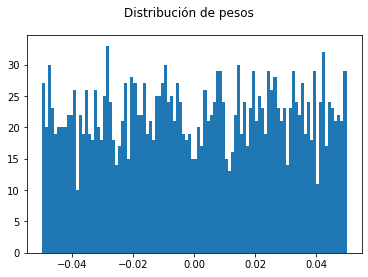

In [59]:
weights = model.get_weights()[0]
biases = model.get_weights()[1]

fig, ax1 = plt.subplots(1)
fig.suptitle('Distribución de pesos')
ax1.hist(weights.flatten(),100)
plt.show()

In [60]:
from tensorflow.keras import callbacks

In [61]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 1s 683us/step - loss: 0.0313 - rmspe: 0.9490 - mse: 0.0313


[0.03133544698357582, 0.9489999413490295, 0.03133544698357582]

In [62]:
np.sqrt(0.0516)

0.22715633383201095

In [63]:
epochs = 5
model.compile(optimizers.Adam(lr=0.001), loss='mse', metrics=[rmspe, 'mse'])
cbs = [callbacks.ReduceLROnPlateau(monitor='val_rmspe', mode='min', verbose=1, patience=2), callbacks.ModelCheckpoint('best_val_rmspe.hdf5', monitor='val_rmspe', mode='min', verbose=1, save_best_only=True)]
if final_train:
    model.fit(X_train, y_train, epochs=epochs, callbacks=cbs)
else:
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=cbs)

Epoch 1/5
26386/26386 [==============================] - 21s 781us/step - loss: 0.0019 - rmspe: 0.2823 - mse: 0.0019
Epoch 2/5
26386/26386 [==============================] - 30s 1ms/step - loss: 0.0018 - rmspe: 0.2665 - mse: 0.0018
Epoch 3/5
26386/26386 [==============================] - 27s 1ms/step - loss: 0.0018 - rmspe: 0.2648 - mse: 0.0018
Epoch 4/5
26386/26386 [==============================] - 26s 1ms/step - loss: 0.0017 - rmspe: 0.2639 - mse: 0.0017
Epoch 5/5
26386/26386 [==============================] - 26s 971us/step - loss: 0.0017 - rmspe: 0.2633 - mse: 0.0017


In [64]:
model.load_weights('best_val_rmspe.hdf5')

ValueError: You are trying to load a weight file containing 2 layers into a model with 4 layers.

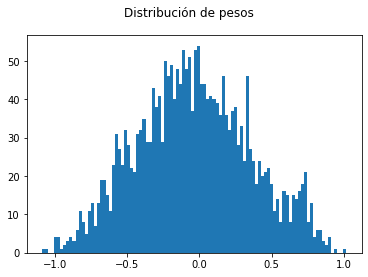

In [65]:
weights = model.get_weights()[0]
biases = model.get_weights()[1]

fig, ax1 = plt.subplots(1)
fig.suptitle('Distribución de pesos')
ax1.hist(weights.flatten(),100)
plt.show()


In [66]:
model.evaluate(X_train, y_train)

26386/26386 [==============================] - 16s 608us/step - loss: 0.0017 - rmspe: 0.2302 - mse: 0.0017


[0.001725885202176869, 0.23015093803405762, 0.001725885202176869]

In [67]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 1s 653us/step - loss: 0.0013 - rmspe: 0.2070 - mse: 0.0013


[0.0013108111452311277, 0.2070227414369583, 0.0013108111452311277]

In [68]:
from matplotlib import pyplot as plt

In [69]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 2)


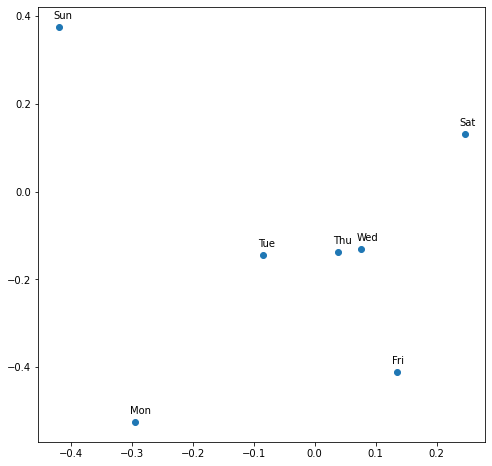

In [70]:
plot_embed('DayOfWeek_embedding', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(1115, 2)


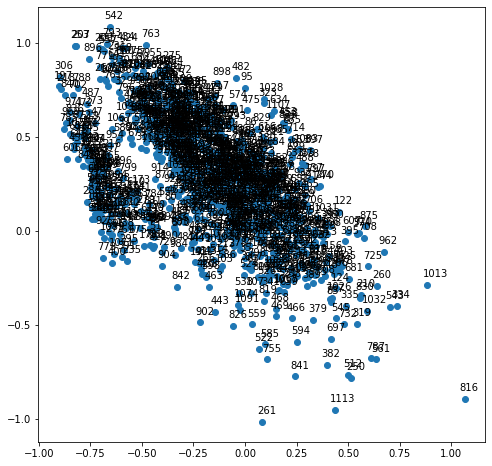

In [71]:
plot_embed('Store_embedding', list(range(1115)))

In [72]:
train_predictions = model.predict(X_train)*max_sales
#get_metric(df_train['Sales'].values, train_predictions.reshape(-1))

In [73]:
test_predictions = model.predict(X_test)*max_sales
test_predictions[df_test['Open'] == 0] = 0

In [74]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = test_predictions
sample_csv.head()

sample_csv.to_csv(f'submision_baseline_{"-".join(X_columns)}.csv', index=False)


In [77]:
!kaggle competitions submit -c rossmann-store-sales -f "submision_baseline_{"-".join(X_columns)}.csv" -m "baseline"


  0%|          | 0.00/617k [00:00<?, ?B/s]
  1%|1         | 8.00k/617k [00:00<00:09, 65.5kB/s]
 35%|###5      | 216k/617k [00:00<00:00, 1.07MB/s] 
 95%|#########4| 584k/617k [00:00<00:00, 2.14MB/s]
100%|##########| 617k/617k [00:02<00:00, 233kB/s] 



Successfully submitted to Rossmann Store Sales
